Dans les deux phases précédentes, nous avons récupéré des données provenant de plusieurs sources internet et nous les avons préparées pour la phase présente. 

# Apprentissage

**Dans cette partie, nous allons essayer de développer un modèle qui prédise avec le moins d'écart avec la réalité possible le revenu moyen dans un département.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import script as sc
import seaborn as sn
plt.rcParams["figure.figsize"] = (6,6)

In [2]:
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoLars

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

from sklearn.metrics import max_error
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
from script import analyse, df_y, verif_overfitting, verif_apprentissage, metriques, data, valeurs_predites, coefficients, df_pred, X_train, y_train, X_test, y_test 

In [4]:
data = pd.read_csv("df_final.csv")

## Récupération du data frame 

La **variable à expliquer est le revenu moyen** ($y$ un vecteur de dimension $n\times 1$). On se sert des autres variables pour réaliser les prédictions ($X$ une matrice de dimension $n\times p$). 

In [5]:
data=data.set_index('departement')
X=['pop_2018' , 'densite', 'pop_municipale', 'hab_m', 'pib_2000', 'décla','impot']
y=['revenu_moyen']
data

,pop_2018,pop_municipale,pib_2005,pib_2000,décla,taxe_om,impot,revenu_moyen
departement,,,,,,,,
S e i n e - M a r i t i m e,1.400178,1.467691,0.804694,0.813841,0.181380,0.402477,0.355252,0.818381
M a y e n n e,-0.448801,-0.467665,0.186693,0.335703,-0.036772,1.836945,-0.742385,-0.442013
A i n,0.214849,0.140654,0.000861,0.104687,1.805399,-0.355005,0.711642,0.665208
H a u t e - G a r o n n e,1.643362,1.486023,1.512274,1.373262,1.137722,-0.565531,1.300313,2.070022
E u r e - e t - L o i r,-0.205376,-0.214773,-0.231912,0.105945,0.511638,0.542828,0.077427,0.752735
...,...,...,...,...,...,...,...,...
J u r a,-0.541051,-0.561408,-0.071275,0.154514,0.236469,-0.260062,-0.306291,-0.135667
A r i è g e,-0.748945,-0.784833,-0.659776,-0.850582,-1.014874,-0.247678,-0.965557,-0.481400
C h e r,-0.455964,-0.458108,-0.123600,-0.136647,-0.299546,-0.216718,-0.480501,-0.131291


Comme dit précédemment, nous avons :

* Une variable dépendante $y$ quantitative et continue, 
* Toutes nos variables explicatives $X$ sont quantitatives également,
* Nous avons peu de données et elles sont structurées et normales,
* Il existe des points extrêmes dans notre échantillon, 
* Certaines de nos variables sont corrélées.

Nous allons donc naturellement nous orienter vers des méthodes de **régression**, plutôt simples. 

## Réalisation de plusieurs modèles 

* On commence par des régressions simples pour aller vers des méthodes ensemblistes plus complexes. 
* On propose plusieurs modèles qu'on essaye de tuner grâce à GridSearchCV.  
* Les modèles sont optimisés selon la métrique de la moyenne de l'erreur au carré. 

**Plus précisément, on cherche à élaborer un modèle avec une moyenne des erreurs au carré inférieure à 0,3 et un R2 supérieur à 0,7.**

La procédure est la suivante, on divise notre base de données en deux échantillons : 
* un échantillon de test 
* un échantillon d'apprentissage (2/3 des données soit environ 60 individus).

Ensuite, selon le modèle, on propose un **dictionnaire d'hyperparamètres qui sera utilisé pour chercher le meilleur modèle parmi toutes les combinaisons d'hyperparamètres**.

Les métriques observées seront : 
* NMSE : La moyenne des erreurs au carré :
$$ NMSE(y, \hat{y})=- \frac{1}{n}\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2$$

* NMAE : La moyenne des écarts absolus dont la formule est :
$$ NMAE(y, \hat{y})=- \frac{1}{n}\sum_{i=1}^{n}|y_{i}-\hat{y}_{i}|$$

* MaxError : L'erreur maximale qui est l'erreur maximale commise par le modèle entre $y_i$ et $\hat{y}_i$.

* R2 : Le coefficient de déterminantion nous donne une indication de l'adaptation du modèle au données.
$$R2(y, \hat{y})=1-\frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^2}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^2}$$

### Régression linéaire ou polynomiale

La régression tente de trouver des coefficients tels que
$y=f(X)$. Plus précisément, on cherche les $\beta_i$ tels que $$y=\alpha + \beta_1 X_1 ... + \beta_n X_n +\epsilon$$ où $n$ est le nombre de variables, $\alpha$ la constante et $\epsilon$ l'erreur du modèle. On cherche à minimiser $\epsilon$. La fonction utilisée pour cela est LinearRegression de Sklearn.

On donne la possibilité d'avoir une régression polynomiale en utilisant le **pipeline** suivant :

`` " Pipeline([('scaler', PolynomialFeatures()), ('lin_reg', LinearRegression())]) " ``


Les **paramètres testés** par GridSearchCV sont :

``param_grid={'scaler__interaction_only':['False','True'],
           'scaler__degree':[1, 2],
           'lin_reg__normalize':['False','True'],
           'scaler__include_bias':['False','True'],
           'lin_reg__fit_intercept':['False', 'True']}``

In [6]:
print("Les métriques obtenues sont :")
mod_linreg, best_para_linreg, best_score_linreg = analyse('Lin_reg', data)

Les métriques obtenues sont :
NMAE : -0.36721612977343754
MaxErr : -1.4603987433845873
R2 : 0.7442939792952454
NMSE : -0.11587210591898778


In [7]:
print("Les meilleurs paramètres sont :")
best_para_linreg

Les meilleurs paramètres sont :


{'lin_reg__fit_intercept': 'False',
 'lin_reg__normalize': 'False',
 'scaler__degree': 1,
 'scaler__include_bias': 'False',
 'scaler__interaction_only': 'False'}

### Régression Ridge

Nous passons maintenant à une regression Ridge qui est une régression linéaire avec une pénalisation quadratique sur les coefficients.  L'expression numérique du problème d'optimisation peut s'écrire de la sorte : 
$$min_{\beta} E(\alpha, \beta)=\sum_{i=1}^{n}(y_{i}-X_{i}\beta)^{2}+\alpha||\beta||^2$$

Nous testons les **hyperparamètres** suivants dans la fonction GridSearchCV :

``param_grid2={'alpha':[0.01, 0.05, 0.1, 0.5, 1],
              'fit_intercept': ['True',  'False'],
              'normalize': ['True',  'False'],
              'copy_X': ['True',  'False'],
              'max_iter':[500, 1000, 1500],
              'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}``

In [8]:
print("Les métriques obtenues sont : ")
mod_ridge,best_para_ridge, best_score_ridge = analyse('Ridge', data)

Les métriques obtenues sont : 
NMAE : -0.3234689067558602
MaxErr : -1.4091960957111747
R2 : 0.7692020700563094
NMSE : -0.14531119404902074


In [9]:
print("Les meilleurs paramètres sont : ")
best_para_ridge

Les meilleurs paramètres sont : 


{'alpha': 0.5,
 'copy_X': 'False',
 'fit_intercept': 'False',
 'max_iter': 1500,
 'normalize': 'True',
 'solver': 'saga'}

### Régression Lasso

Dans la régression Lasso, les coefficients sont obtenus en minimisant la somme des carrés des résidus mais avec une pénalisation en plus. Le problème de minimisation s'écrit comme cela :

$$ min_{\beta_1...\beta_p}\frac{1}{2}\sum_{i=1}^{n}\bigg(y_i-\beta_{0}-\sum_{j=1}^{p}\beta_{j}x_{i,j}\bigg)$$

sous la contrainte $\sum_{j=1}^{p}|\beta_j|\leq t$. Le paramètre $t$ contrôle donc le niveau de régularisation des coefficients estimés. Il est possible que les coefficients associés à certaines variables soient nuls. 

Les **hyperparamètres testés** par GridSearchCV sont : 
    
``param_grid3={'fit_intercept':['False','True'],
           'alpha':[0.01, 0.05, 0.1, 0.5, 1],
           'normalize':['False','True'],
           'positive':['False', 'True'],
           'random_state':[0],
           'selection':['cyclic', 'random'],
           'copy_X':['False','True'],
           'warm_start':['False','True']}``

In [10]:
print("Les métriques obtenues sont : ")
mod_lasso, best_para_lasso, best_score_lasso = analyse('Lasso', data)

Les métriques obtenues sont : 
NMAE : -0.33170488883893967
MaxErr : -1.2534290344146441
R2 : 0.7953899532007335
NMSE : -0.1266301473635028


In [11]:
print("Les meilleurs paramètres sont : ")
best_para_lasso

Les meilleurs paramètres sont : 


{'alpha': 0.01,
 'copy_X': 'False',
 'fit_intercept': 'False',
 'normalize': 'False',
 'positive': 'False',
 'random_state': 0,
 'selection': 'cyclic',
 'warm_start': 'False'}

### Méthodes ensemblistes 

#### Forêt aléatoire

Les **paramètres testés** par GridSearchCV sont les suivants :
    
``param_grid6={'n_estimators': [5, 8, 10, 25, 50],
          'max_depth': [2, 3, 4],
          'max_features':[2, 'auto', 'sqrt', 'log2'],
          'min_samples_split': [2, 3, 4],
          'bootstrap': ['True', 'False'],
          'max_samples':[2, 3, 4],
          'warm_start':['False','True']}``

In [12]:
print("Les métriques obtenues sont : ")
mod_RandF, best_para_RandF, best_score_RandF = analyse('RandF', data)

Les métriques obtenues sont : 
NMSE : -1.0041030115147873
MAE : 0.511731096523219
R2 : 0.28139643439337725
MaxError : 6.144201312910283


In [13]:
print("Les meilleurs paramètres sont : ")
best_para_RandF

Les meilleurs paramètres sont : 


{'bootstrap': 'False',
 'max_depth': 3,
 'max_features': 5,
 'max_samples': 4,
 'min_samples_split': 4,
 'n_estimators': 5,
 'warm_start': 'True'}

#### AdaBoost

Les **hyperparamètres testés** par GridSearchCV sont :
    
``param_grid7={'n_estimators': [5, 8, 10, 25, 50],
          'base_estimator':[DecisionTreeRegressor(), LinearRegression()],
          'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
          'loss':['linear', 'square', 'exponential']}``

In [14]:
print("Les métriques obtenues sont : ")
mod_AdaBoost, best_para_AdaBoost, best_score_AdaBoost = analyse('AdaBoost', data)

Les métriques obtenues sont : 
NMAE : -0.4328117006447698
MaxErr : -2.8864390540898683
R2 : 0.6782642930707221
NMSE : -0.11799904797192781


In [15]:
print("Les meilleurs paramètres sont : ")
best_para_AdaBoost

Les meilleurs paramètres sont : 


{'base_estimator': LinearRegression(),
 'learning_rate': 0.1,
 'loss': 'linear',
 'n_estimators': 8}

#### Bagging

La technique de bagging est un estimateur ensembliste qui permet d'entraîner plusieurs modèles faibles sur plusieurs échantillons des données originelles et d'en aggréger les prédictions individuelles pour former une prédiction finale. Comme pour le boosting, cet algorithme peut se baser sur d'autres estimateurs faibles comme les arbres de décision. 

Les **hyperparamètres testés** par GridSearchCV sont les suivants :

``param_grid8={'warm_start': ['False', 'True'],
          'base_estimator':[DecisionTreeRegressor(), LinearRegression()],
          'n_estimators':[5, 8, 10, 25, 50],
          'bootstrap':['True', 'False'],
          'max_features': [0.5, 1],
          'n_jobs':[1, 2, 3],
          'random_state':[0]}``

In [16]:
print("Les métriques obtenues sont : ")
mod_Bagging, best_para_Bagging, best_score_Bagging = analyse('Bagging', data)

Les métriques obtenues sont : 
MAE : 0.2575353004495904
R2 : 0.910240331718206
MaxError : 1.216567973938563
NMSE : -0.12542096581198364


In [17]:
print("Les meilleurs paramètres sont : ")
best_para_Bagging

Les meilleurs paramètres sont : 


{'base_estimator': LinearRegression(),
 'bootstrap': 'True',
 'max_features': 0.5,
 'n_estimators': 10,
 'n_jobs': 1,
 'random_state': 0,
 'warm_start': 'False'}

On peut conclure que **les modèles les plus simples ne sont pas forcément les plus mauvais**. 

Parmis les modèles qui obtiennent les meilleures métriques, on a les **régressions Ridge et Lasso et le bagging**.

## Choix du meilleur modèle 

Nous allons observer quelques graphiques afin de valider notre choix de modèle final.

### Overfitting

On essaye de **détecter le surapprentissage dans les modèles Ridge, Lasso et Bagging**.
* On utilise pour cela la fonction validation_curve avec cinq validations croisées. 
* Si la courbe correspondant au score d'entraînement et celle correspondant au score de validation sont toutes les deux basses, alors l'estimateur est en sous-apprentissage.
* Si le score d'apprentissage est très haut et le score de validation est bas, alors on en en situation de surapprentissage, sinon, c'est que le modèle marche bien.
* La métrique considérée est la moyenne des erreurs au carré.

#### Régression Lasso

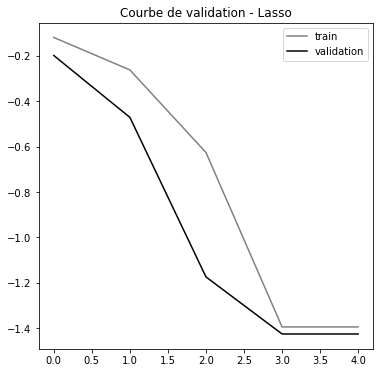

In [18]:
train_scores_lasso, valid_scores_lasso = verif_overfitting('Lasso', mod_lasso.best_estimator_, data)

On voit qu'il y a **un peu d'overfitting**.

#### Bagging

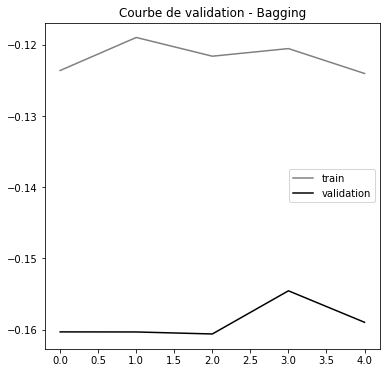

In [19]:
train_scores_bagging, valid_scores_bagging = verif_overfitting('Bagging', mod_Bagging.best_estimator_, data)

Sans surprise, on observe qu'il y a de **l'overfitting mais pas tant que cela**. 

#### Régression Ridge

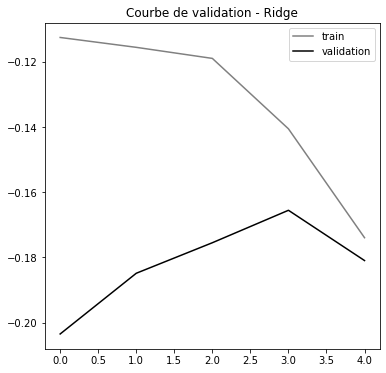

In [20]:
train_scores_ridge, valid_scores_ridge = verif_overfitting('Ridge', mod_ridge.best_estimator_, data)

Dans ce cas, il y a un **peu d'overfitting**. Ce modèle ne semble pas être le meilleur car il présente la MAE la plus haute sur les données de validation.

### Courbe d'apprentissage

Dans cette partie, nous cherchons à savoir si notre modèle **pourrait être plus performant s'il bénéficiait de plus de données**. 
* Si les courbes sont dans une phase de croissance, alors cela peut être le signe que le modèle aurait pu être plus efficace avec plus de données. 
* La métrique considérée est la moyenne des erreurs au carré.

#### Régression Lasso

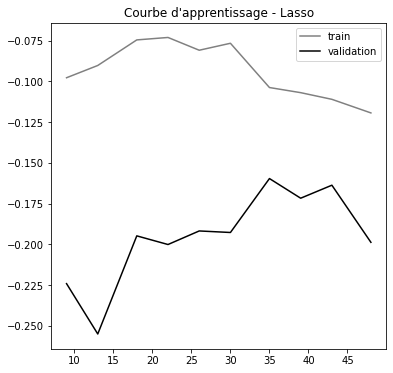

In [21]:
train_sizes_lasso2, train_scores_lasso2, valid_scores_lasso2 = verif_apprentissage('Lasso', mod_lasso.best_estimator_, data)

La courbe sur les données d'entraînement est décroissante. Notre modèle semble avoir **assez de données**.

#### Bagging

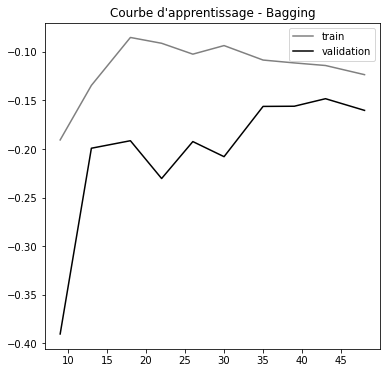

In [22]:
train_sizes_bagging2, train_scores_bagging2, valid_scores_bagging2 = verif_apprentissage('Bagging', mod_Bagging.best_estimator_, data)

La courbe est dans une phase **stationnaire voire décroissante**. 

#### Régression Ridge

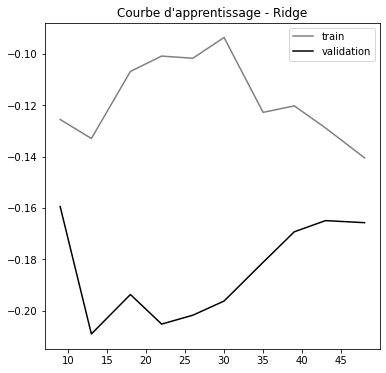

In [23]:
train_sizes_ridge2, train_scores_ridge2, valid_scores_ridge2 = verif_apprentissage('Ridge', mod_ridge.best_estimator_, data)

La courbe sur les données de validation est encore stable.

**La régression Lasso semble être le meilleur modèle** car elle présente des métriques intéressantes. On arrête donc notre choix sur ce modèle.

## Prédictions 

On a donc choisi le **modèle Lasso** comme meilleur modèle. On va réaliser les prévisions mais on commence par observer les **coefficients associés à chaque variable**.

In [24]:
coefficients(X_train, mod_lasso)

COEFFICIENTS DE CHAQUE FEATURE
pop_2018 : 0.1391559192669821
pop_municipale : 0.0
pib_2005 : 0.0
pib_2000 : 0.13562948406901154
décla : 0.12320411050792204
taxe_om : 0.0
impot : 0.5612698792059113


In [25]:
revenu_moyen_prédit= mod_lasso.best_estimator_.predict(X_test)
array_test=np.array(y_test)

On peut finalement observer les **métriques sur les données de test** afin de savoir si elles correspondent à nos attentes. 

In [26]:
metriques(y_test,revenu_moyen_prédit)

METRIQUES SUR LES DONNEES DE TEST
MSE : 0.26345
R2 : 0.82159
MaxError : 2.10314
MAE : 0.34172


On réalise les prédictions et on observe les **valeurs prédites et les valeurs réelles du revenu moyen**. 

In [33]:
y_test=df_y(y_test, revenu_moyen_prédit)
y_test.head()

,revenu_moyen,predit,erreur
departement,,,
L o i r - e t - C h e r,0.166302,-0.105511,0.060791
L o t - e t - G a r o n n e,-0.568928,-0.311606,0.257322
D o u b s,0.083151,0.619678,-0.536527
C h e r,-0.131291,-0.265173,-0.133882
S e i n e - M a r i t i m e,0.818381,0.650369,0.168012


On peut aussi observer la **distribution des résidus** de notre régression. 

Observation des résidus


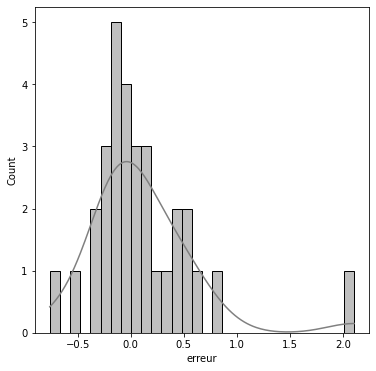

In [34]:
print("Observation des résidus")
g=sn.histplot(data=y_test, x="erreur", kde=True, bins=30, color="gray")

**L'erreur maximale** est commise pour le département suivant. 

In [29]:
y_test[ y_test['erreur'] == y_test['erreur'].max() ]

,revenu_moyen,predit,erreur
departement,,,
Y v e l i n e s,5.776805,3.673667,2.103138


Pour finir, on peut observer le département pour lequel le **salaire moyen prédit est le plus élevé sur les données test**.

In [30]:
y_test[ y_test['predit'] == y_test['predit'].max() ]

,revenu_moyen,predit,erreur
departement,,,
Y v e l i n e s,5.776805,3.673667,2.103138


## Récapitulatif sur les données 

Le modèle nous permet de conclure que le département dont on prévoit qu'il aura le **revenu moyen le plus élevé** est le suivant.

In [31]:
df_pred(data, mod_lasso)

,pop_2018,pop_municipale,pib_2005,pib_2000,décla,taxe_om,impot,revenu_moyen,predit
departement,,,,,,,,,
H a u t s - d e - S e i n e,2.108039,2.144775,10.859388,10.640075,5.786118,0.332301,7.255337,7.07221,6.644936


# Réponse à la problématique et conclusion

* Au cours de notre étude, nous avons donc commencé par réaliser un **web scraping des données sur diverses pages web** et les avons **condensées en un data frame**.
* Par la suite, nous avons **traité le data frame afin de le rendre exploitable**. 
* Nous avons terminé par réaliser la phase de **machine learning** au cours de laquelle nous avons entraîné plusieurs modèles sur nos données afin de trouver le plus performant. 

Pour conclure, on peut dire que c'est le **modèle Lasso qui semble être le meilleur**. Sur nos données test :
* une moyenne des erreurs au carré de : 0,26 inférieure à 0,3
* un R2 de : 0,54 donc supérieur à 0,7 ce qui répond à nos objectifs.

Les variables qui ont le coefficient le plus important sont : *pop_2018*, *pib_2000*, *décla*, *impot*.


Selon notre modèle, le département qui fournit le plus haut salaire moyen est le département des Hauts-de-Seine. Globalement, on comprend bien que la **région parisienne dans son ensemble fournit les meilleurs salaires car le niveau des prix est plus élevé qu'ailleurs en France**. 

Les **principales difficultés** rencontrées au cours de cette étude sont :
* Réaliser du web scraping sans pouvoir utiliser Selenium.
* Les pages web changent régulièrement ce qui amène à adapter le code souvent.
* Mettre en place un modèle de machine learning avec si peu de données (étude qui s'assimile plus à de la statistique inférentielle).

On peut mettre en lumière quelques unes des **faiblesses** de notre étude :
* D'abord, nous avons très peu de données.
* De plus, les disparités économiques géographiques qui existent en France se font sentir dans nos analyses.
* La complexité du cas parisien n'a pas pu être prise en compte dans notre étude car Paris est un département trop particulier par rapport aux autres de telle sorte que l'intégrer à notre étude démultiplierait les erreurs. 
* De même, le caractère frontalier de certains département n'est pas pris en compte. 

En guise d'ouverture, on peut proposer de tenter de répondre à la même problématique mais cette fois-ci dans **plusieurs villes de France**. Cela nous permettrait d'avoir une base de données plus conséquente et cela pourrait réduire l'effet que les inégalités géographiques exercent sur notre étude.